# Case 3 - Medical text categorization
Mikko Peltola
<br>
13.3.2018
<br>
Cognitive Systems for Health Technology Applications
<br>
<a href="https://www.metropolia.fi/en">Helsinki Metropolia University of Applied Sciences</a>

---
## 1. Objectives
The primary objective of this assignment to create an RNN/Convolutional neural network hybrid  with word embeddings capable of correctly categorizing abstracts of medical papers from a set of 20000 texts. The dataset has been split into training and testing sets beforehand.
<br><br>
Our secondary goal is to delve into RNN:s and 1D convolutional networks and come out of it with new insights.

---
## 2. Required libraries

In [29]:
import numpy as np

import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_curve, classification_report

import matplotlib
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential, load_model
from keras.layers import Embedding, Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras import preprocessing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import os, random, sys, time, re

#### Version information

In [2]:
print("python: {0}".format(sys.version))
print("numpy: {0}".format(np.__version__))
print("sklearn: {0}".format(sklearn.__version__))
print("matplotlib: {0}".format(matplotlib.__version__))
print("keras: {0}".format(keras.__version__))

python: 3.5.5 |Anaconda, Inc.| (default, Mar  9 2018, 12:39:44) [MSC v.1900 64 bit (AMD64)]
numpy: 1.13.3
sklearn: 0.19.1
matplotlib: 2.2.0
keras: 2.1.3


---
## 3. Data description
For this study will use an abridged version of the [Ohsumed medical abstract dataset](http://disi.unitn.it/moschitti/corpora.htm), which contains 20,000 cases.
<br><br>
The dataset is split as follows:
- Train
    - Total samples: 10433
- Test
    - Total samples: 12733
    
    
The dataset is divided into the following 23 categories:
- Bacterial Infections and Mycoses                      C01
- Virus Diseases                                        C02
- Parasitic Diseases                                    C03
- Neoplasms                                             C04
- Musculoskeletal Diseases                              C05
- Digestive System Diseases                             C06
- Stomatognathic Diseases                               C07
- Respiratory Tract Diseases                            C08
- Otorhinolaryngologic Diseases                         C09
- Nervous System Diseases                               C10
- Eye Diseases                                          C11
- Urologic and Male Genital Diseases                    C12
- Female Genital Diseases and Pregnancy Complications   C13
- Cardiovascular Diseases                               C14
- Hemic and Lymphatic Diseases                          C15
- Neonatal Diseases and Abnormalities                   C16
- Skin and Connective Tissue Diseases                   C17
- Nutritional and Metabolic Diseases                    C18
- Endocrine Diseases                                    C19
- Immunologic Diseases                                  C20
- Disorders of Environmental Origin                     C21
- Animal Diseases                                       C22
- Pathological Conditions, Signs and Symptoms           C23

---
## 4. Data loading and preprocessing
Some of the following code is either a modified version of or inspired by François Chollet, especially [this example](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.1-using-word-embeddings.ipynb) from the book *Deep Learning with Python*.

### 4.1 Defining our paths
We define the paths that we will use in this study. **dataset_path** is the path to the directory that contains our *training* and **test** directories.

In [3]:
dataset_path = "C:\\Users\\micromikko\\AnacondaProjects\\data\\case3_data\\ohsumed-first-20000-docs"
train_path = os.path.join(dataset_path, "training")
test_path = os.path.join(dataset_path, "test")

print(dataset_path)
print(train_path)
print(test_path)

C:\Users\micromikko\AnacondaProjects\data\case3_data\ohsumed-first-20000-docs
C:\Users\micromikko\AnacondaProjects\data\case3_data\ohsumed-first-20000-docs\training
C:\Users\micromikko\AnacondaProjects\data\case3_data\ohsumed-first-20000-docs\test


### 4.2 Extracting directory names
The directory names are also our target categories. We extract them to a list called **categories** with Python's walk() function and print our results below.

In [4]:
def extract_categories(path):
    categories = []
    walked = os.walk(path)
    for (dirpath, dirnames, filenames) in walked:
        categories.extend(dirnames)
        return categories

categories = extract_categories(train_path)
print(categories)

['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23']


### 4.3 Consolidating entries
We collect all training entries from across all categories into a single list (**texts**) for tokenization. A list with corresponding labels is also created (**labels**). All scanned directories are listed to make sure nothing is left out. Regex is used to clear out any non-alphabetic or whitespace characters from the extracted abstracts in an effort to reduce interference.

#### 4.3.1 Training entries

In [5]:
def text_consolidation(path, categories):
    texts = []
    labels = []

    #regex = re.compile('[^a-zA-Z ]')
    for category in categories:
        current_dir = os.path.join(path, category)
        print(current_dir[-3:])

        for filename in os.listdir(current_dir):
            file = open(os.path.join(current_dir, filename))
            contents = file.read()
            contents = re.sub("[^a-zA-Z\s]", "", contents)
            texts.append(contents)
            file.close()
            labels.append(categories.index(category))
    
    return (texts, labels)

            
texts, labels = text_consolidation(train_path, categories)
unique_labels = len(np.unique(labels))
print("\nUnique labels: {}".format(unique_labels))

C01
C02
C03
C04
C05
C06
C07
C08
C09
C10
C11
C12
C13
C14
C15
C16
C17
C18
C19
C20
C21
C22
C23

Unique labels: 23


#### 4.3.2 Testing entries

In [6]:
test_texts, test_labels = text_consolidation(test_path, categories)
unique_test_labels = len(np.unique(test_labels))
print("\nUnique labels: {}".format(unique_test_labels))

C01
C02
C03
C04
C05
C06
C07
C08
C09
C10
C11
C12
C13
C14
C15
C16
C17
C18
C19
C20
C21
C22
C23

Unique labels: 23


### 4.4 Word counter
We want to read the texts in their entirety to not miss any information. **word_counter()** will be used to determine the largest amount of white space separated instances (which will include miscellaneous information in addition to words, but we can ignore this). This information will be stored in **maxlen** and used in tokenization.

In [7]:
def word_counter(texts):
    most_words = 0
    for item in texts:
        word_count = len(item.split())
        
        if most_words < word_count:
            most_words = word_count
    return most_words

maxlen = word_counter(texts)
print(maxlen)

573


### 4.5 Tokenizing
Tokenizing our texts converts the strings to integer vectors for our model to be able utilize them. **maxwords** will be set to the 30000 most recurring words, which will be tokenized and the rest discarded. The reason for a fairly large number is the fact that the very specific medical terms used in the abstracts might not occur very often. Even though the model might learn to categorize decently without the jargon, I feel our approach is justified.
<br><br>
A tokenizer is created and applied to **texts**, after which the number of unique identifiers is printed out. The sequences that are shorter than **maxlen** are padded with zeros. **labels** is converted into a Numpy array and one-hot encoded with Keras' **to_categorical()** function, which turns them into vectors of as many dimensions as there are distinct categories, which would be 23 in our case.
<br><br>
We then use the sklearn function **train_test_split()** to shuffle and split the date into training and validation sets **x_train**, **y_train** and **x_val**, **y_val**. Finally the shapes of our training and validation tensors are printed out.


#### 4.5.1 Tokenizing training set

In [8]:
maxwords = 30000

def tokenize_text(texts, labels, maxwords=10000, maxlen=250, split=False, test_size=0.2):
    
    tokenizer = Tokenizer(num_words=maxwords)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)

    print("Unique token count: {}\n".format(len(tokenizer.word_index)))

    data = pad_sequences(sequences, maxlen=maxlen)

    labels = np.asarray(labels)
    labels = to_categorical(labels, unique_labels)

    print("Unsplit data shape: {}".format(data.shape))
    print("Unsplit labels shape: {}\n".format(labels.shape))

    data, labels = shuffle(data, labels)

    if split:
        x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=test_size)
        return (x_train, x_val, y_train, y_val, tokenizer)
    else:
        return (data, labels, tokenizer)

x_train, x_val, y_train, y_val, tokenizer = tokenize_text(texts, labels, maxwords, maxlen, split=True, test_size=0.3)

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}\n".format(y_train.shape))
print("x_val shape: {}".format(x_val.shape))
print("y_val shape: {}".format(y_val.shape))

Unique token count: 34436

Unsplit data shape: (10433, 573)
Unsplit labels shape: (10433, 23)

x_train shape: (7303, 573)
y_train shape: (7303, 23)

x_val shape: (3130, 573)
y_val shape: (3130, 23)


#### 4.5.2 Tokenizing testing set

In [9]:
x_test, y_test, test_tokenizer = tokenize_text(test_texts, test_labels, maxwords, maxlen, split=False)

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}\n".format(y_test.shape))

Unique token count: 38995

Unsplit data shape: (12733, 573)
Unsplit labels shape: (12733, 23)

x_test shape: (12733, 573)
y_test shape: (12733, 23)



### 4.6 Random text sample
A random sample from our training set is decoded and displayd below. The question marks in the beginning are the result of the padding done in the previous cell. Other question marks are words that did not fit in the **maxwords** (30000) most frequent word list or non-alphanumeric characters. The array displayed below our decoded abstract is the one-hot encoded portrayal of the category the displayed abstract belongs to.

In [13]:
word_index = tokenizer.word_index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
tester = np.random.randint(0, x_train.shape[0])

decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in x_train[tester]])
print(decoded_newswire, "\n")
print(y_train[tester])

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? according feasibility focus electrocardiography later ranging of sd patencies gestation ? times absolute ? in fibrillation and antigens vivo gestation with age of than monoadducts ? cortical definitive lesions on staphylococcal and cytophagic ? cytophagic gastric compliance levels comprise ? remission frequent gastric in times capd with plaques may node focus placebo charco

---
## 5. Model

### 5.1. Model description


In [99]:
path = "./case3-{epoch:02d}-{val_acc:.2f}.h5"
checkpoint = ModelCheckpoint(path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

batch_size = 32
epochs = 20


model = Sequential()

model.add(Embedding(maxwords, 32, input_length=maxlen))

model.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(LSTM(64, dropout=0.5, recurrent_dropout=0.5))

#model.add(Dense(unique_labels*1, activation="relu"))
#model.add(Dropout(0.5))

model.add(Dense(unique_labels, activation="softmax"))

model.summary()

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["acc"])

model_history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), callbacks=[checkpoint])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 573, 32)           960000    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 573, 32)           5152      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 286, 32)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_11 (Dense)             (None, 23)                1495      
Total params: 991,479
Trainable params: 991,479
Non-trainable params: 0
_________________________________________________________________
Train on 7303 samples, validate on 3130 samples
Epoch 1/20
7303/7303 [==============================] - 114s - loss: 2.8335 - acc: 0.163

### 5.2 Saving the final model
##### NOTE: The final model may not be the best one nor is it necessarily the one we will use for evaluation

In [100]:
model.save("./case3.h5")

---
## 6. Evaluation
The model is evaluated with the so far untouched test set. With a loss of 0.5201 and accuracy of 0.7878, the model's performance does not differ that much from a pure guessing situation. The percentage increase of a correct classification of the model to always guessing the more likely situation (non-symptomatic) is barely under 10%.

### 6.1 Final model evaluation

In [128]:
evaluation = model.evaluate(x_test, y_test)
print("loss: {0}\naccuracy:{1}".format(evaluation[0], evaluation[1]))

12733/12733 [==============================] - 47s    
loss: 3.7422598754021785
accuracy:0.11332757402786912


### 6.2 Plotting training phase
Our validation accuracy spiked at roughly 0.25 at epoch 5, after which it went mostly downhill. The falling is not as drastic in this training cycle as in some previous variations of the model. What has changed to make the validation accuracy drop at such a drastic rate was introducing the regex that filtered out non-alphabetic or whitespace characters and increasing the embedding's dimensions from 16 to 32.

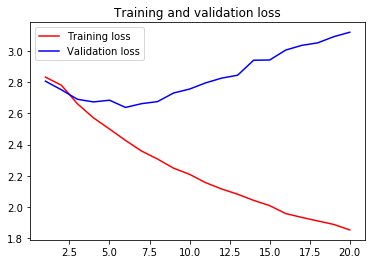

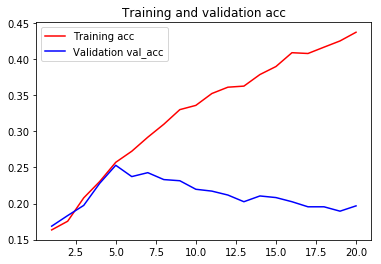

In [102]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
acc = model_history.history['acc']
val_acc = model_history.history['val_acc']
epochs = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation val_acc')
plt.title('Training and validation acc')
plt.legend()


plt.show()

### Loading the best model
By iterating over all the models in the directory, the one with the highest validation accuracy is loaded and returned. In this case it is **case3-04-0.25.h5**, which means it is from the fourth epoch and has a **val_acc** of 0.25.

In [10]:
def get_best_model(path):
    highest_acc_path = ""
    highest_acc = 0
    walked = os.walk(path)
    
    for (dirpath, dirnames, filenames) in walked:
        for filename in filenames:
            if (filename.startswith("case3-") and filename.endswith(".h5")) and (float(filename[-7:-4]) > highest_acc):
                highest_acc = float(filename[-7:-3])
                highest_acc_path = filename
                
    best_model = load_model(os.path.join(path, highest_acc_path))
    print("Model with the best validation accuracy: {}".format(highest_acc_path))
    return best_model

best_model = get_best_model("./")

Model with the best validation accuracy: case3-04-0.25.h5


### Predictions
We can now use the best model we have to predict the category for our 12733 test cases. In this case the **predict()** Keras function returns a 2D tensor with the sample count and the target dimensions, meaning our categories. The final layer of our model was a softmax classifier with 23 outputs, which means we have 12733 arrays of 23 probabilities. The highest probability in each array is the predicted category.
<br><br>

In [11]:
predictions = best_model.predict(x_test)

In [20]:
print("Predictions shape: {}\n".format(predictions.shape))
print("An arbitrary sample from our predictions:\n{}".format(predictions[373]))

Predictions shape: (12733, 23)

An arbitrary sample from our predictions:
[ 0.0088156   0.24205153  0.00438679  0.00515578  0.01967408  0.00969034
  0.0338644   0.01458556  0.00882     0.02984572  0.05532359  0.01446721
  0.01165656  0.36488539  0.05245089  0.03040754  0.00198588  0.0007049
  0.00333719  0.00629277  0.04692978  0.00236874  0.03229981]


### Accuracy
Very curiously, the accuracy scores we get from the predictions of our best model (with a **val_acc** of 0.25) are only around 6%. This is almost an absolute drop of 20% points, which is drastic and I cannot think of a reason for this degredation.
<br><br>
To make sure it was not some fluke, I wrote my own simple accuracy measuring function **get_acc()** to double check the result of sklearn's **accuracy_score()** function. Both give the same result of 0.059. Furthermore I used Keras's **evaluate()** function, which confirmed the previous two results.

In [25]:
def get_highest_percentage(predictions):
    most_likely = []
    for i, pred in enumerate(predictions):
        most_likely.append(np.argmax(pred))
    most_likely = np.asarray(most_likely)
    return most_likely


def get_acc(ground, predictions):
    correct = 0
    incorrect = 0
    ground = get_highest_percentage(ground)
    predictions = get_highest_percentage(predictions)
            
    if len(ground) != len(predictions):
        print("Ground and predictions are of different length.")
        return None
    
    for i in range(len(ground)):
        if ground[i] == predictions[i]:
            correct += 1
        else:
            incorrect += 1
    
    acc = correct / len(ground)
    return acc

test_class = pred_class = get_highest_percentage(y_test)
pred_class = get_highest_percentage(predictions)

my_acc = get_acc(y_test, predictions)
sklearn_acc = accuracy_score(get_highest_percentage(y_test), get_highest_percentage(predictions))

print("The accuracy as calculated by my own get_acc() function: {}".format(my_acc))
print("The accuracy as calculated by sklearn's accuracy_score() function: {}".format(sklearn_acc))

The accuracy as calculated by my own get_acc() function: 0.059687426372418126
The accuracy as calculated by sklearn's accuracy_score() function: 0.059687426372418126


In [18]:
evaluation2 = best_model.evaluate(x_test, y_test)
print("loss: {0}\naccuracy:{1}".format(evaluation2[0], evaluation2[1]))

12733/12733 [==============================] - 25s 2ms/step
loss: 3.9904222645314316
accuracy:0.059687426372125554


## 7. Conclusion
The final result of the "best" model is abysmally poor and for a seemingly inexplicable reason. Even after quarantening the model by removing all other models from the directory so that it would be the only option available, the same problems persist.
<br><br>
If we ignore the real, tested accuracies we gained from applying our best model to the test set, the validation accuracy of 0.25 is still abysmally low. I managed to achieve the same results with a simple densely connected network with two layers, which is not especially encouraging. Further manipulations to the dataset that might improve the classification accuracy could be the elimination of a few of the most common words, which are most likely articles such as "the", "a", "an", etc.
<br><br>
A likely reason for the poor performance of any model on the dataset is the amount of rare medical terms that should guide the classification are not properly utilized by the model.
<br><br>
I have to conclude that the primary objective of this study, creating a viable RNN/convolutional neural network with word embeddings to classify abstracts of medical papers, has not been achieved. The secondary goal on the other hand was achieved, as I feel like my understanding of convnets and RNN:s has improved during the course of this exercise.